# 01 – Data Exploration

This notebook performs **initial data exploration (EDA)** for the flight price prediction project.

### Purpose of this notebook
- Understand the structure and quality of the original dataset
- Perform light data cleaning and sanity checks
- Explore how original attributes relate to price
- Prepare a clean dataset for feature engineering (Notebook 02)

Note that the data used here is generated with openAI and not real data, hence findings may not be the most accurate. However, sample data generated comes with anomalies which needs cleaning.

In [42]:
#Importing Relevant Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import (
    StructType, StructField,
    StringType, IntegerType, LongType, DoubleType, FloatType,
    BooleanType, DateType, TimestampType
)

# pip install pandas matplotlib seaborn

In [43]:
spark = SparkSession.builder.appName("Flights").getOrCreate()

# Load CSV safely with Pandas
pandas_df = pd.read_csv("../Data/Raw/flight_data_1year.csv")
# Convert to Spark
df = spark.createDataFrame(pandas_df)
# Do Spark processing
df.show(5)

+------------+--------------+------+-----------+-------+------+-----+
|booking_date|departure_date|origin|destination|airline| price|stops|
+------------+--------------+------+-----------+-------+------+-----+
|  2023-09-20|    2024-01-01|   JFK|        LAX|  Delta|591.78|    0|
|  2023-12-11|    2024-01-01|   JFK|        LAX| United|801.22|    0|
|  2023-10-18|    2024-01-01|   LHR|        CDG|Ryanair|152.24|    0|
|  2023-08-23|    2024-01-01|   BOM|        DEL| Indigo|   NaN|    0|
|  2023-12-30|    2024-01-01|   SYD|        MEL| Qantas|563.71|    0|
+------------+--------------+------+-----------+-------+------+-----+
only showing top 5 rows


In [44]:
num_rows = df.count()
num_cols = len(df.columns)
print(f"Rows: {num_rows}, Columns: {num_cols}")

Rows: 1860, Columns: 7


There are 1860 rows with 7 columns 
- [booking_date, departure_date, origin, destination, airline, price, stops]    

In [45]:
# Inspect schema and data types
df.printSchema()

root
 |-- booking_date: string (nullable = true)
 |-- departure_date: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- price: double (nullable = true)
 |-- stops: long (nullable = true)



In [46]:
# Check missing values
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------------+--------------+------+-----------+-------+-----+-----+
|booking_date|departure_date|origin|destination|airline|price|stops|
+------------+--------------+------+-----------+-------+-----+-----+
|           0|             0|     0|          0|      0|    0|    0|
+------------+--------------+------+-----------+-------+-----+-----+



In [47]:
# Data Type Conversion
# Convert date columns to datetime
date_cols = ['departure_date', 'booking_date']
for c in date_cols:
    df = df.withColumn(c, F.to_date(F.col(c), 'yyyy-MM-dd'))  # adjust format if needed

# Convert numeric columns
numeric_cols = {'price': DoubleType(), 'stops': IntegerType()}
for c, dtype in numeric_cols.items():
    df = df.withColumn(c, F.col(c).cast(dtype))

# Convert categorical columns to string
categorical_cols = [c for c, t in df.dtypes if t not in ('double', 'int', 'bigint', 'float')]
for c in categorical_cols:
    df = df.withColumn(c, F.col(c).cast(StringType()))

# Check types
df.printSchema()


root
 |-- booking_date: string (nullable = true)
 |-- departure_date: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- price: double (nullable = true)
 |-- stops: integer (nullable = true)



In [48]:
# Group by all columns and count occurrences
dup_count = (
    df.groupBy(df.columns)
      .count()
      .filter(F.col("count") > 1)      
      .agg(F.sum(F.col("count") - 1))   
      .collect()[0][0]
)

print(f"Number of duplicate rows: {dup_count}")

Number of duplicate rows: 1


Therefore, after observing the data, we can see that there are empty field in the "price" column and 30 duplicate rows. 

For the duplicate rows and empty price fields, we will remove them.

Since we are trying to predict the prices, there would not be any meaning in replacing their values as it may corrupt the values and give rise to a poor accuracy.




In [49]:
df = df.dropDuplicates()
dup_count = (
    df.groupBy(df.columns)
      .count()
      .filter(F.col("count") > 1)      
      .agg(F.sum(F.col("count") - 1))   
      .collect()[0][0]
)

print(f"Number of duplicate rows: {dup_count}")

Number of duplicate rows: None


In [50]:
# Check missing values
df = df.dropna(subset= ["price"])
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------------+--------------+------+-----------+-------+-----+-----+
|booking_date|departure_date|origin|destination|airline|price|stops|
+------------+--------------+------+-----------+-------+-----+-----+
|           0|             0|     0|          0|      0|    0|    0|
+------------+--------------+------+-----------+-------+-----+-----+



In [51]:
df.describe().show()

+-------+------------+--------------+------+-----------+-------+------------------+-------------------+
|summary|booking_date|departure_date|origin|destination|airline|             price|              stops|
+-------+------------+--------------+------+-----------+-------+------------------+-------------------+
|  count|        1809|          1809|  1809|       1809|   1809|              1809|               1809|
|   mean|        NULL|          NULL|  NULL|       NULL|   NULL|362.43783858485364|0.16362631288004423|
| stddev|        NULL|          NULL|  NULL|       NULL|   NULL|230.87895078988208| 0.3700384243587951|
|    min|  2023-07-12|    2024-01-01|   BOM|        CDG|  Delta|              50.0|                  0|
|    max|  2024-12-11|    2024-12-31|   SYD|        MEL| United|           3094.04|                  1|
+-------+------------+--------------+------+-----------+-------+------------------+-------------------+



In [52]:
# Sanity Check for dates
invalid_dates_count = df.filter(F.col("booking_date") > F.col("departure_date")).count()

print(f"Number of rows where booking_date > departure_date: {invalid_dates_count}")

Number of rows where booking_date > departure_date: 0


In [53]:
# Explicit sanity checks
invalid_price_count = df.filter(F.col("price") <= 0).count()
print(f"Rows with non-positive price: {invalid_price_count}")

missing_price_count = df.filter(F.col("price").isNull()).count()
print(f"Rows with missing price: {missing_price_count}")

Rows with non-positive price: 0
Rows with missing price: 0


## Saving Cleaned Dataset

The cleaned dataset is saved to disk. This dataset:
- Has valid price values
- Has correctly typed date columns
- Contains no engineered features or capped values

This clean handoff ensures downstream notebooks remain modular and reproducible.

In [54]:
pdf = df.toPandas()
pdf.to_csv('../Data/Cleaned/cleaned_flight_data.csv', index = False)

# Exploratory Data Analysis

### Departure Month

The following plot is used to understand how the departure month relates to **flight price**. Visual inspection helps reveal distribution patterns, outliers, and potential pricing drivers.

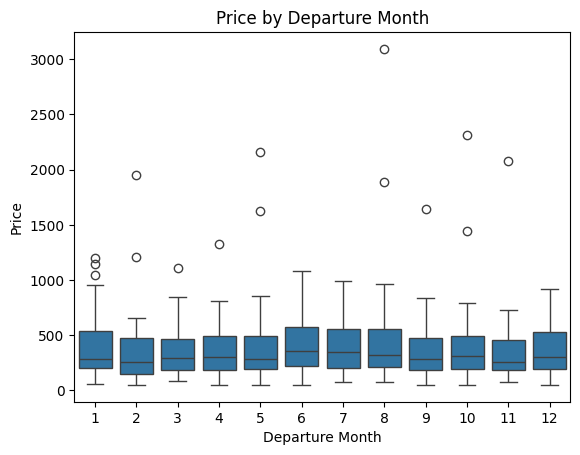

In [55]:
df = df.withColumn('dep_month', F.month(F.col('departure_date')))
pdf = df.toPandas() 

sns.boxplot(
    x='dep_month',
    y='price',
    data=pdf
)
plt.title('Price by Departure Month')
plt.xlabel('Departure Month')
plt.ylabel('Price')
plt.show()


## Price by Departure Month — Interpretation

This boxplot shows the distribution of flight prices grouped by **departure month**.  
Each box represents the **interquartile range (IQR)** (middle 50% of prices), the horizontal line inside the box is the **median**, and the whiskers and points indicate **spread and outliers**.

### Key observations
- Some months (e.g. **June–August** and **October–December**) show **slightly higher median prices**, suggesting seasonal demand effects.
- Other months (e.g. **February–April**) tend to have marginally lower medians.
- **Price distributions overlap heavily across all months**, indicating that month alone does not strongly separate prices.

### Understanding overlap and variance
Although median prices differ slightly by month, the **within-month price variability** is large:
- The **interquartile ranges overlap significantly**, meaning many prices in a “cheaper” month are higher than prices in a “more expensive” month.
- The **spread (variance)** within each month is larger than the difference between monthly medians.

This suggests that **departure month on its own is a weak predictor of price**.

### Conclusion
Departure month reflects **broad seasonal trends**, but due to high variance and overlapping price distributions, it should be treated as a **secondary feature** rather than a primary driver of flight prices.


## Route

The following plot is used to understand how the route taken relates to **flight price**. Visual inspection helps reveal distribution patterns, outliers, and potential pricing drivers.

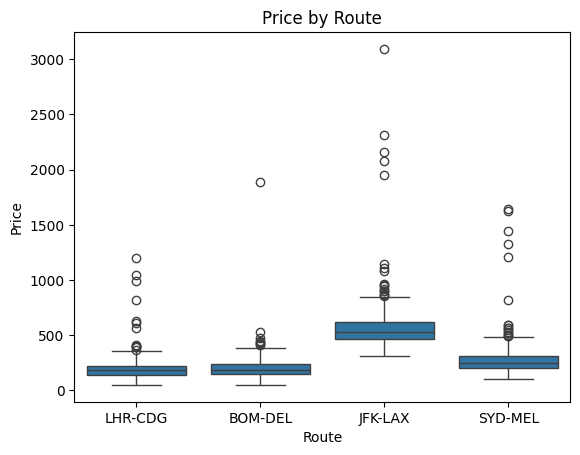

In [56]:
df = df.withColumn("route", F.concat_ws("-", F.col("origin"), F.col("destination")))
pdf = df.toPandas()
sns.boxplot(
    x='route',
    y='price',
    data=pdf
)
plt.title('Price by Route')
plt.xlabel('Route')
plt.ylabel('Price')
plt.show()


## Price by Route — Interpretation

This boxplot compares the distribution of flight prices across different **routes**.  
Each route aggregates prices from multiple airlines, booking dates, and departure dates.

### Key observations
- **JFK–LAX** has the **highest median price** and the **widest spread**, indicating this is the most expensive and volatile route.
- **LHR–CDG** shows the **lowest median prices** with a relatively tight interquartile range, reflecting short-haul, high-frequency flights.
- **SYD–MEL** sits between long-haul and short-haul routes, with moderate median prices but noticeable outliers.
- **BOM–DEL** has low to moderate median prices and a smaller spread compared to JFK–LAX.

### Understanding spread and outliers
- Long-haul routes (e.g. **JFK–LAX**) show:
  - Larger **price variability**
  - More **high-price outliers**, likely due to demand surges, last-minute bookings, or premium fare classes
- Short-haul routes (e.g. **LHR–CDG**) have:
  - Tighter price distributions
  - Fewer extreme values

### Relationship strength
Route shows a **strong relationship with price**:
- Median prices differ significantly between routes
- Interquartile ranges overlap much less than in time-based features (e.g. day or month)

This indicates that **route is one of the strongest predictors of flight price**.

### Conclusion
Unlike temporal features, **route clearly segments price levels**.  
This confirms that route is a **high-impact explanatory variable** and should be retained for both EDA insights and machine learning modeling.


## Airlines

The following plot is used to understand how the type of airlines relates to **flight price**. Visual inspection helps reveal distribution patterns, outliers, and potential pricing drivers.

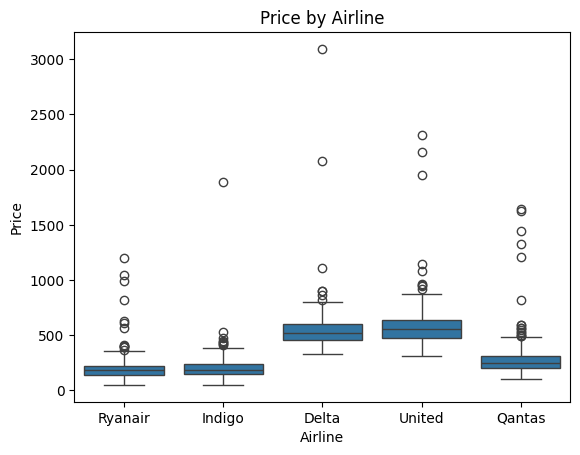

In [57]:
sns.boxplot(
    x='airline',
    y='price',
    data=pdf
)
plt.title('Price by Airline')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.show()


## Price by Airline — Interpretation

This boxplot compares flight price distributions across different **airlines**.  
Each airline includes flights from multiple routes, booking times, and seasons.

### Key observations
- **United** and **Delta** have the **highest median prices**, indicating full-service carriers with generally higher base fares.
- **Ryanair** shows the **lowest median price** and the tightest interquartile range, consistent with a low-cost carrier pricing model.
- **Qantas** sits in the mid-to-high price range, with noticeable high-price outliers likely driven by long-haul routes.
- **Indigo** has relatively low median prices, similar to other budget-focused airlines.

### Spread and variability
- Full-service airlines (Delta, United, Qantas) exhibit:
  - Larger **price variability**
  - More **extreme outliers**, reflecting fare classes, demand surges, and last-minute pricing
- Low-cost carriers (Ryanair, Indigo) show:
  - Narrower distributions
  - Fewer high-price outliers

### Relationship with price
Airline shows a **moderate to strong relationship** with price:
- Median prices differ clearly between airlines
- However, there is still **overlap in interquartile ranges**, especially among full-service carriers

This suggests airline alone does not fully determine price, but it is a **significant contributing factor**.

### Conclusion
Airline pricing strategies clearly influence flight prices, but the effect is **less dominant than route**.  
This makes airline a **secondary but important feature** for predictive modeling.


## Number of Stops

The following plot is used to understand how the number of stops relates to **flight price**. Visual inspection helps reveal distribution patterns, outliers, and potential pricing drivers.

In [58]:
df.groupBy("stops").agg(F.mean("price").alias("avg_price")).orderBy("stops").show()

+-----+-----------------+
|stops|        avg_price|
+-----+-----------------+
|    0|363.7087309980166|
|    1|355.9416891891887|
+-----+-----------------+



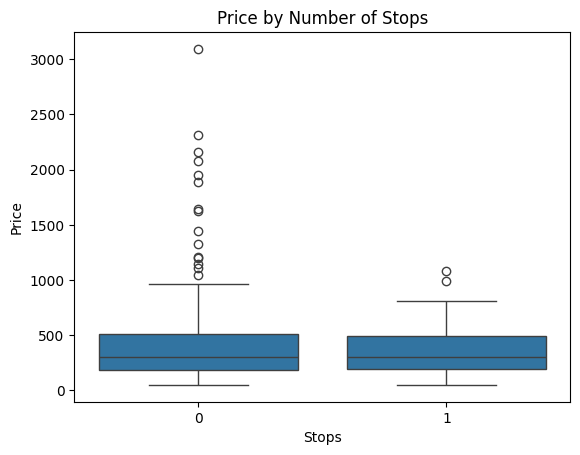

In [59]:
sns.boxplot(
    x='stops',
    y='price',
    data=pdf
)
plt.title('Price by Number of Stops')
plt.xlabel('Stops')
plt.ylabel('Price')
plt.show()


## Price by Number of Stops — Interpretation

This boxplot compares flight price distributions based on the **number of stops** (non-stop vs one-stop flights).

### Key observations
- **Non-stop flights (0 stops)** have a **slightly higher median price** compared to one-stop flights.
- **One-stop flights (1 stop)** tend to be cheaper on average, reflecting the common pricing trade-off between convenience and cost.
- The difference in median prices is present but **not very large**.

### Spread and variability
- Non-stop flights show:
  - A **wider price distribution**
  - More **high-price outliers**, likely driven by business travel and premium convenience pricing
- One-stop flights have:
  - Fewer extreme outliers
  - Slightly tighter interquartile range

### Relationship strength
The number of stops has a **weak to moderate relationship** with price:
- There is substantial **overlap** between the two distributions
- Many one-stop flights are priced similarly to non-stop flights

This suggests that while stops influence price, they do not strongly separate fare levels on their own.

### Conclusion
Number of stops affects flight pricing in an intuitive way, but the effect size is relatively small.  
This feature adds incremental value when combined with other predictors rather than acting as a dominant driver.


## Days Before Departure

The following plot is used to understand how the number of stops relates to **flight price**. Visual inspection helps reveal distribution patterns, outliers, and potential pricing drivers.

In [60]:
df = df.withColumn(
    "days_before_departure",
    F.datediff(F.col("departure_date"), F.col("booking_date"))
)
df.show(5)

+------------+--------------+------+-----------+-------+------+-----+---------+-------+---------------------+
|booking_date|departure_date|origin|destination|airline| price|stops|dep_month|  route|days_before_departure|
+------------+--------------+------+-----------+-------+------+-----+---------+-------+---------------------+
|  2023-09-03|    2024-01-05|   LHR|        CDG|Ryanair|133.89|    0|        1|LHR-CDG|                  124|
|  2023-08-03|    2024-01-14|   BOM|        DEL| Indigo|159.62|    0|        1|BOM-DEL|                  164|
|  2023-11-19|    2024-01-10|   LHR|        CDG|Ryanair|264.91|    0|        1|LHR-CDG|                   52|
|  2023-09-11|    2024-02-03|   BOM|        DEL| Indigo|116.21|    0|        2|BOM-DEL|                  145|
|  2023-10-26|    2024-01-06|   LHR|        CDG|Ryanair|223.21|    0|        1|LHR-CDG|                   72|
+------------+--------------+------+-----------+-------+------+-----+---------+-------+---------------------+
only showi

In [61]:
df.agg(F.max("days_before_departure").alias("max_days")).show()

+--------+
|max_days|
+--------+
|     179|
+--------+



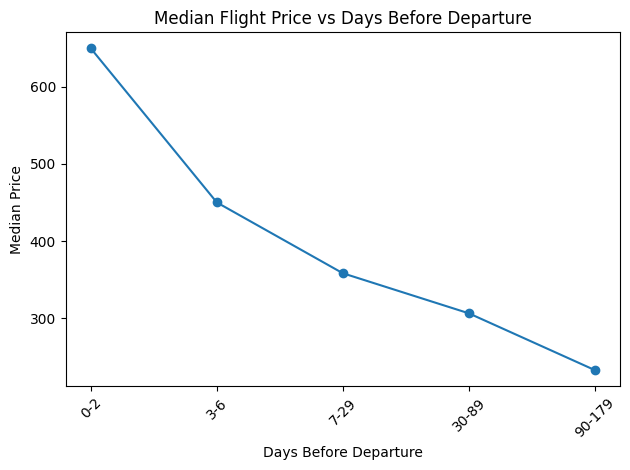

In [65]:
df = df.withColumn(
    "lead_time_bin",
    F.when(F.col("days_before_departure") < 3, "0-2")
     .when((F.col("days_before_departure") >= 3) & (F.col("days_before_departure") < 7), "3-6")
     .when((F.col("days_before_departure") >= 7) & (F.col("days_before_departure") < 30), "7-29")
     .when((F.col("days_before_departure") >= 30) & (F.col("days_before_departure") < 90), "30-89")
     .when((F.col("days_before_departure") >= 90) & (F.col("days_before_departure") < 180), "90-179")
     .otherwise("180+")
)

df = df.withColumn(
    "lead_time_order",
    F.when(F.col("lead_time_bin")=="0-2", 0)
     .when(F.col("lead_time_bin")=="3-6", 1)
     .when(F.col("lead_time_bin")=="7-29", 2)
     .when(F.col("lead_time_bin")=="30-89", 3)
     .when(F.col("lead_time_bin")=="90-179", 4)
     .otherwise(5)
)

lead_stats_spark = df.groupBy("lead_time_bin", "lead_time_order") \
.agg(F.expr("percentile_approx(price, 0.5)").alias("median_price")) \
.orderBy("lead_time_order")

lead_stats = lead_stats_spark.toPandas()

plt.figure()
plt.plot(
    lead_stats['lead_time_bin'].astype(str),
    lead_stats['median_price'],
    marker='o',
)
plt.xticks(rotation=45)
plt.xlabel('Days Before Departure')
plt.ylabel('Median Price')
plt.title('Median Flight Price vs Days Before Departure')
plt.tight_layout()
plt.show()

## Price by Days Before Departure — Interpretation

This line chart shows how the **median flight price changes as the number of days before departure increases**.  
Prices are aggregated using **median** values within lead-time bins to reduce the impact of extreme outliers.

### Key observations
- Flights booked **very close to departure (0–3 days)** have the **highest median prices**.
- Median prices **decrease steadily** as the booking window increases.
- The **lowest prices** are observed for flights booked **90–180 days in advance**.

This indicates a clear **negative relationship** between days before departure and price.

### Trend interpretation
- The downward slope reflects common airline pricing behavior:
  - Last-minute bookings face limited seat availability and higher demand
  - Early bookings benefit from advance-purchase discounts
- The relationship is **monotonic and smooth**, suggesting a strong and consistent pattern rather than random variation

### Why bins are used
- Individual booking dates are noisy and sparse
- Binning smooths short-term fluctuations and highlights the **underlying pricing trend**
- Median values further reduce the impact of extreme last-minute or premium fares

### Relationship strength
Days before departure shows a **strong relationship with price**:
- Clear directional trend
- Large difference between early and late booking medians
- Minimal overlap between distant bins

This makes it one of the **most informative predictors** identified during EDA.


### Conclusion
Booking lead time is a **primary driver of flight price behavior**.  
This feature captures consumer urgency and airline yield management strategies, making it essential for downstream modeling and buy-or-wait decision logic.


## Day of Flight

The following plot is used to understand how the day of flight relates to **flight price**. Visual inspection helps reveal distribution patterns, outliers, and potential pricing drivers.

In [66]:
from pyspark.sql import functions as F

# Add departure_day column
df = df.withColumn("departure_day", F.date_format(F.col("departure_date"), "EEEE"))  # full day name

# Add numeric sort key for correct order
day_order_dict = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

df = df.withColumn(
    "day_order",
    F.create_map([F.lit(x) for t in day_order_dict.items() for x in t])[F.col("departure_day")]
)

# Compute median and std using Spark
day_stats_spark = df.groupBy("departure_day", "day_order").agg(
    F.expr("percentile_approx(price, 0.5)").alias("median_price"),
    F.stddev("price").alias("std_price")
).orderBy("day_order")

day_stats_spark.show()


+-------------+---------+------------+------------------+
|departure_day|day_order|median_price|         std_price|
+-------------+---------+------------+------------------+
|       Monday|        0|      263.41|164.77477262971325|
|      Tuesday|        1|      269.23|194.12051071416673|
|    Wednesday|        2|      268.67|183.21451099864206|
|     Thursday|        3|      299.72|260.14402165923826|
|       Friday|        4|      339.64| 260.0178758435776|
|     Saturday|        5|      321.51|216.56214953961634|
|       Sunday|        6|       320.1| 290.3551924472875|
+-------------+---------+------------+------------------+



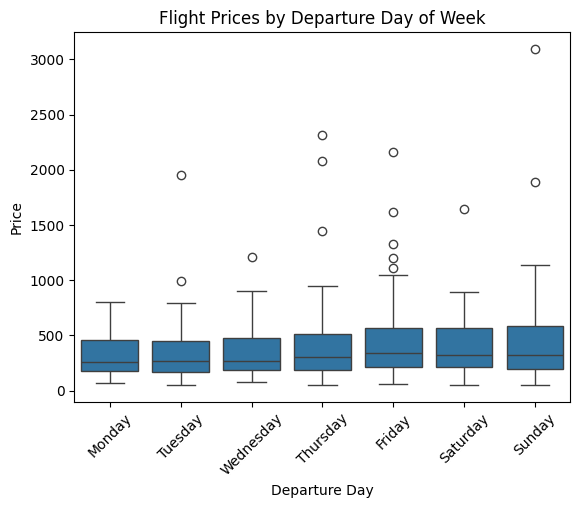

In [67]:
pdf = df.toPandas()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pdf['departure_day'] = pd.Categorical(pdf['departure_day'], categories=day_order, ordered=True)

sns.boxplot(
    data= pdf,
    x='departure_day',
    y='price',
    order=day_order
)
plt.xticks(rotation=45)
plt.xlabel("Departure Day")
plt.ylabel("Price")
plt.title('Flight Prices by Departure Day of Week')
plt.show()

## Flight Prices by Departure Day of Week — Interpretation

This boxplot compares flight price distributions across different **days of the week**.

### Key observations
- Median prices are **slightly higher on Fridays and weekends (Saturday, Sunday)**.
- Midweek departures (Monday–Wednesday) tend to have **lower median prices**.
- Thursday appears to act as a transition day, with prices rising toward the weekend.

### Spread and overlap
- All days show **substantial overlap** in price distributions.
- The interquartile ranges across weekdays are similar, indicating that:
  - Day of week alone does not strongly separate price levels
- Weekend days show:
  - Slightly higher variability
  - More extreme high-price outliers

### Relationship strength
Departure day of week has a **weak to moderate relationship** with price:
- Directionally intuitive (weekends cost more)
- Effect size is small compared to lead time or route

### Conclusion
Day-of-week effects exist but are subtle.  
This feature provides contextual information rather than a dominant pricing signal.


### Holidays

The following plot is used to understand how the holidays relates to **flight price**. Visual inspection helps reveal distribution patterns, outliers, and potential pricing drivers.

In [68]:
# Convert date columns to datetime for time-based analysis
# Load datasets
country_holidays = spark.createDataFrame(pd.read_csv("../Data/Raw/PublicHolidaysfor2024.csv"))
country_holidays = country_holidays.withColumn("date", F.to_date(F.col("date"), "yyyy-MM-dd"))
df = df.join(
    F.broadcast(country_holidays),
    df.departure_date == country_holidays.date,
    how="left"
).withColumn(
    "is_holiday",
    F.when(F.col("date").isNotNull(), True).otherwise(False)
).drop("date")

df.groupBy("is_holiday").agg(
    F.expr("percentile_approx(price, 0.5)").alias("median_price")
).show()

+----------+------------+
|is_holiday|median_price|
+----------+------------+
|      true|       316.9|
|     false|      298.79|
+----------+------------+



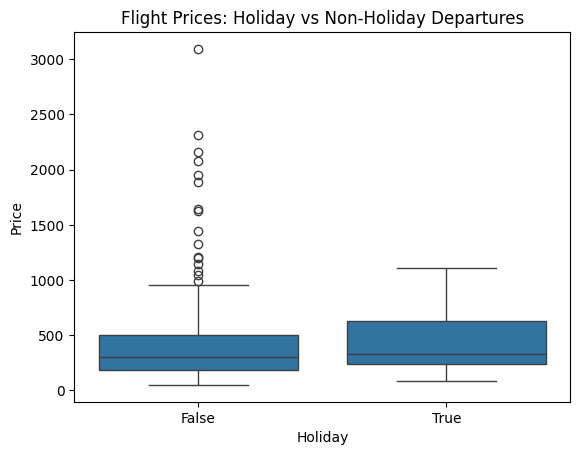

In [69]:

sns.boxplot(
    data=df.toPandas(),
    x='is_holiday',
    y='price'
)
plt.title('Flight Prices: Holiday vs Non-Holiday Departures')
plt.xlabel('Holiday')
plt.ylabel('Price')
plt.show()


## Flight Prices: Holiday vs Non-Holiday Departures — Interpretation

This boxplot compares flight prices between **holiday** and **non-holiday** departure dates.

### Key observations
- Flights departing on holidays have a **higher median price** than non-holiday flights.
- Holiday departures also show **greater price variability**.

### Spread and outliers
- Holiday flights exhibit:
  - A wider interquartile range
  - More high-price outliers
- This reflects demand spikes, limited seat availability, and peak travel behavior during public holidays

### Relationship strength
Holiday status has a **moderate relationship** with price:
- Median prices differ clearly
- However, there is still overlap between the two distributions

This indicates that holiday effects increase prices but do not override other pricing drivers.


### Conclusion
Public holidays systematically raise flight prices, but their impact is conditional on other factors.  
Holiday status provides valuable signal when combined with temporal and route-based features.


## Season

The following plot is used to understand how the season relates to **flight price**. Visual inspection helps reveal distribution patterns, outliers, and potential pricing drivers.

In [70]:
df = df.withColumn(
    "month", F.month(F.col("departure_date"))
)

df = df.withColumn(
    "season",
    F.when(F.col("month").isin([12, 1, 2]), "Winter")
     .when(F.col("month").isin([3, 4, 5]), "Spring")
     .when(F.col("month").isin([6, 7, 8]), "Summer")
     .otherwise("Fall")
)

# Compute median price by season
df.groupBy("season").agg(
    F.expr("percentile_approx(price, 0.5)").alias("median_price")
).orderBy("median_price").show()

+------+------------+
|season|median_price|
+------+------------+
|Winter|      278.57|
|  Fall|      280.59|
|Spring|      291.82|
|Summer|      341.83|
+------+------------+



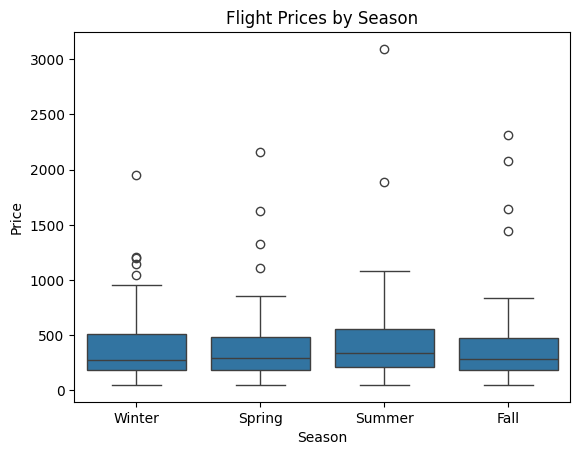

In [71]:
sns.boxplot(
    data=df.toPandas(),
    x='season',
    y='price'
)
plt.title('Flight Prices by Season')
plt.xlabel('Season')
plt.ylabel('Price')
plt.show()

## Flight Prices by Season — Interpretation

This boxplot compares flight price distributions across the four **seasons**: Winter, Spring, Summer, and Fall.

### Key observations
- **Summer** has the **highest median flight prices** among all seasons.
- **Winter** and **Fall** show lower median prices relative to Summer.
- **Spring** sits between Winter and Summer, reflecting a transition into peak travel demand.

### Spread and variability
- Summer exhibits:
  - A **wider interquartile range**
  - More **high-price outliers**, likely due to peak vacation travel and limited seat availability
- Other seasons show relatively tighter distributions, indicating more stable pricing

### Relationship strength
Season has a **moderate relationship** with price:
- Median differences are visible across seasons
- However, there is **substantial overlap** in price distributions

This suggests seasonality affects pricing, but it does not dominate price behavior on its own.

### Interpretation in context
Season captures broad demand patterns:
- Summer corresponds to school holidays and leisure travel peaks
- Winter includes both holiday spikes and off-peak periods
- Fall and Spring represent shoulder seasons with mixed demand

Because seasons aggregate many underlying factors (holidays, weather, travel habits), their effect is smoother and less sharp than features like lead time or route.


### Conclusion
Seasonality influences flight prices in an intuitive way, but its predictive power is **secondary** compared to lead time and route.  
It provides valuable context rather than a decisive signal on its own.


An interaction analysis between departure day and holidays was explored but omitted due to insufficient observations per subgroup, which limited the reliability of conclusions.

In [72]:
df.show(5)

+------------+--------------+------+-----------+-------+------+-----+---------+-------+---------------------+-------------+---------------+-------------+---------+----+-------+----------+-----+------+
|booking_date|departure_date|origin|destination|airline| price|stops|dep_month|  route|days_before_departure|lead_time_bin|lead_time_order|departure_day|day_order| day|holiday|is_holiday|month|season|
+------------+--------------+------+-----------+-------+------+-----+---------+-------+---------------------+-------------+---------------+-------------+---------+----+-------+----------+-----+------+
|  2023-09-03|    2024-01-05|   LHR|        CDG|Ryanair|133.89|    0|        1|LHR-CDG|                  124|       90-179|              4|       Friday|        4|NULL|   NULL|     false|    1|Winter|
|  2023-08-03|    2024-01-14|   BOM|        DEL| Indigo|159.62|    0|        1|BOM-DEL|                  164|       90-179|              4|       Sunday|        6|NULL|   NULL|     false|    1|Win

## Final Exploratory Data Analysis (EDA) Conclusions

The exploratory data analysis reveals several clear patterns and relationships that explain flight price behavior.  
Overall, flight pricing is driven by a combination of **booking behavior**, **route characteristics**, and **temporal demand factors**, rather than any single attribute.

---

### Strong Predictors of Price

**Days Before Departure**
- Exhibits the **strongest and most consistent relationship** with price
- Prices are significantly higher for last-minute bookings and decrease steadily as lead time increases
- This reflects airline yield management and consumer urgency
- Identified as a **core numerical feature** for modeling

**Route**
- Routes show clear separation in median price levels
- Long-haul routes (e.g. JFK–LAX) are consistently more expensive than short-haul routes (e.g. LHR–CDG)
- Route captures structural cost differences and demand patterns
- Identified as a **high-impact categorical feature**

---

### Moderate Predictors of Price

**Airline**
- Full-service carriers (Delta, United) have higher median prices than low-cost carriers (Ryanair, Indigo)
- Considerable overlap exists across airlines
- Airline influences pricing but does not fully determine it

**Season (Departure Month)**
- As seasons have fixed months, season is used instead since departure month does not behave as a good indicator in flight prices in our EDA above
- This would prevent overfitting of the model and redundancies
- Summer shows the highest median prices due to peak travel demand
- Seasonal effects are visible but smooth and overlapping
- Season provides contextual demand information rather than sharp price separation

**Holiday Indicator**
- Holiday departures have higher median prices and increased variability
- Holiday effects amplify prices but depend on route, season, and lead time

---

### Weak but Useful Predictors

**Day of Week**
- Weekend departures tend to be slightly more expensive
- Differences are small and distributions heavily overlap
- Hence for feature engineering, we will use weekend indicator instead since prices differ more with weekend vs weekday
- Most useful when combined with holiday and season features

**Number of Stops**
- Non-stop flights are marginally more expensive than one-stop flights
- Effect size is small and insufficient as a standalone predictor

---

### Key EDA Takeaways

- Price drivers operate at **different levels**:
  - Structural: route, airline
  - Behavioral: booking lead time
  - Temporal: season, holidays, day of week
- Strong predictors show **clear median separation and directional trends**
- Weaker predictors still contribute value through **feature interactions**

---

### Implications for Feature Engineering

Based on EDA findings:
- All derived temporal features (lead time, season, holiday, weekday) should be retained
- Route and airline should be encoded carefully due to their strong price influence
- Median-based aggregation is preferred due to price skew and outliers
- Feature interactions should be explored in downstream modeling

---

### Transition to Next Notebook

With key patterns identified and validated, the next step is to:
- Engineer robust numerical and categorical features
- Encode high-impact variables appropriately
- Prepare the dataset for baseline and advanced machine learning models

This analysis provides a solid foundation for **Notebook 02: Feature Engineering**.
